In [72]:
import pandas as pd
import numpy as np
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [85]:
# assuming a true exponential decay for X
def true_exponential_decay(x, a, b):
    return a * np.exp(-b * x)


x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
true_exponential_decay_df = pd.DataFrame({
    'BN': x,
    'ET_mean': true_exponential_decay(x, 1, 0.1) * 5000
})

In [86]:
true_exponential_decay_df

,BN,ET_mean
0,1,4524.187090
1,2,4093.653765
2,3,3704.091103
3,4,3351.600230
4,5,3032.653299
5,6,2744.058180
6,7,2482.926519
7,8,2246.644821
8,9,2032.848299
9,10,1839.397206


In [87]:
true_exponential_decay_df['ET_mean'] = true_exponential_decay_df['ET_mean'].round(0).astype(int)
true_exponential_decay_df['ET_std'] = true_exponential_decay_df['ET_mean'] * 0.1
true_exponential_decay_df

,BN,ET_mean,ET_std
0,1,4524,452.4
1,2,4094,409.4
2,3,3704,370.4
3,4,3352,335.2
4,5,3033,303.3
5,6,2744,274.4
6,7,2483,248.3
7,8,2247,224.7
8,9,2033,203.3
9,10,1839,183.9


In [88]:
# using the ET_mean to generate 20 samples for each BN
def generate_samples(df, num_samples=20):
    samples = []
    for _, row in df.iterrows():
        bn = row['BN']
        et_mean = row['ET_mean']
        et_std = row['ET_std']
        sample = np.random.normal(loc=et_mean, scale=et_std, size=num_samples)
        samples.append(pd.DataFrame({'BN': bn, 'ET': sample}))
    return pd.concat(samples, ignore_index=True)
samples_df = generate_samples(true_exponential_decay_df)
samples_df['ET'] = samples_df['ET'].round(0)

In [89]:
samples_df.groupby('BN').agg({'ET': ['mean', 'std']}).reset_index()

BN       ET            
            mean         std
0   1.0  4390.55  442.059233
1   2.0  4063.15  375.960003
2   3.0  3762.15  370.563053
3   4.0  3421.65  329.398539
4   5.0  2998.90  232.760754
5   6.0  2726.85  252.426180
6   7.0  2552.25  215.387991
7   8.0  2248.75  198.314443
8   9.0  1950.45  247.868912
9  10.0  1838.95  169.583228

In [90]:
# take first block as initial mean and variance 
def calculate_initial_mean_variance(df):
    initial_mean = df['ET'].mean()
    initial_variance = df['ET'].var()
    return initial_mean, initial_variance
mu, P = calculate_initial_mean_variance(samples_df[samples_df['BN'] == 1])
print(f"Initial Mean: {mu}, Initial std: {np.sqrt(P)}")

Initial Mean: 4390.55, Initial std: 442.0592333494163


In [91]:
len(true_exponential_decay_df)

10

Block 2.0: Updated Mean: 4200.566382002079, Updated std: 286.3916711106747
Block 3.0: Updated Mean: 4036.6224624295946, Updated std: 226.6033813235507
Block 4.0: Updated Mean: 3839.076100443728, Updated std: 186.69313640750192
Block 5.0: Updated Mean: 3510.1628217042166, Updated std: 145.6348444853364
Block 6.0: Updated Mean: 3314.543181837488, Updated std: 126.14586084527343
Block 7.0: Updated Mean: 3119.8517754495538, Updated std: 108.85136006255645
Block 8.0: Updated Mean: 2918.173191542225, Updated std: 95.42227957034326
Block 9.0: Updated Mean: 2793.2658038908007, Updated std: 89.05135829109454
Block 10.0: Updated Mean: 2586.9930393075415, Updated std: 78.84202733459759


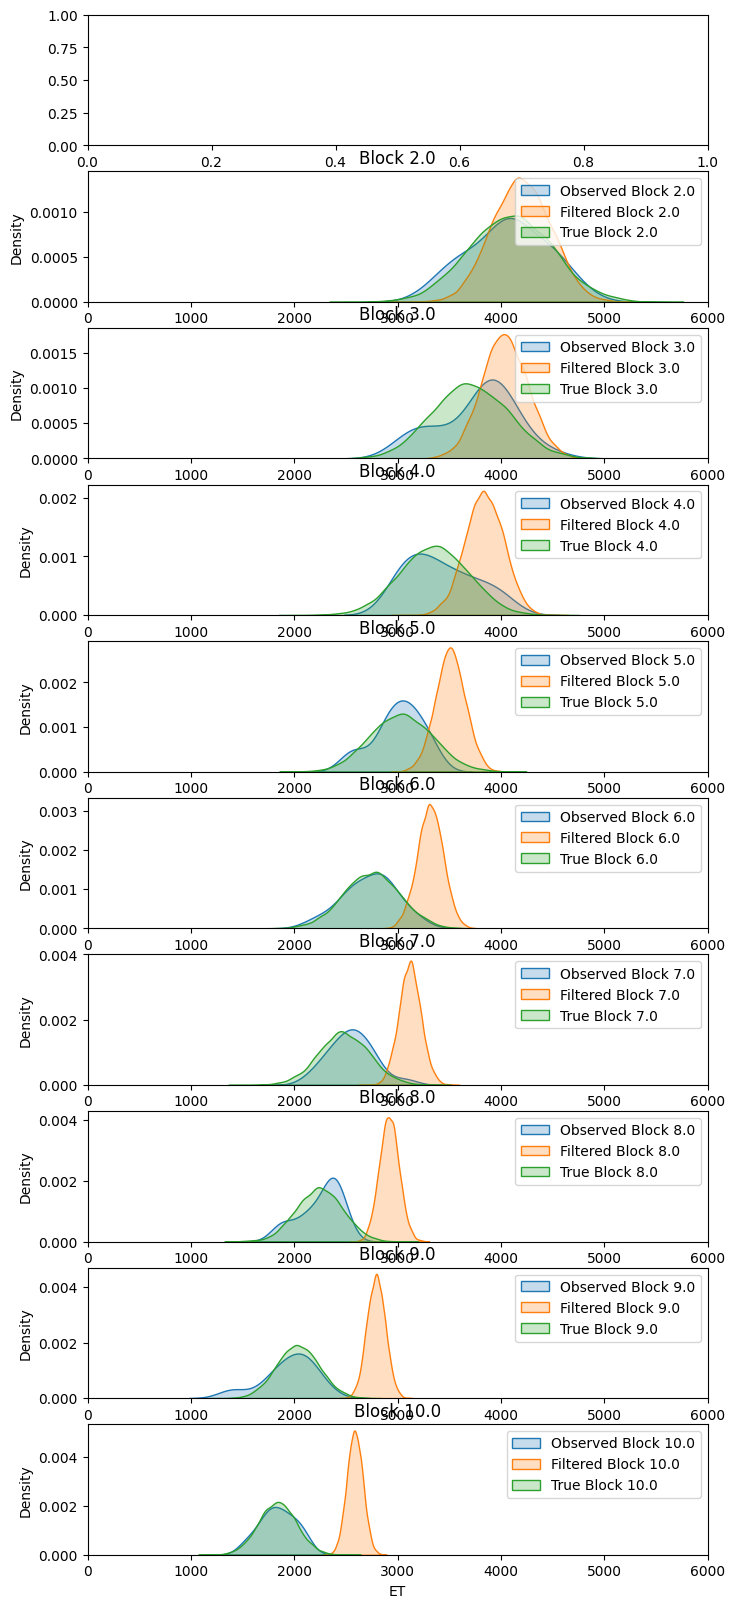

In [92]:
# update kalman filter for each block based on block mean and variance
fig, axs = plt.subplots(len(true_exponential_decay_df), 1, figsize=(8, 20))

for idx, bn in enumerate(samples_df['BN'].unique()):
    if bn == 1:
        continue
    z, r = calculate_initial_mean_variance(samples_df[samples_df['BN'] == bn])
    sns.kdeplot(samples_df[samples_df['BN'] == bn]['ET'], label=f'Observed Block {bn}', fill=True, ax=axs[idx])
    mu = mu + (P / (P + r)) * (z - mu)
    P = (1 - (P / (P + r))) * P
    print(f"Block {bn}: Updated Mean: {mu}, Updated std: {np.sqrt(P)}")
    data = np.random.normal(loc=mu, scale=np.sqrt(P), size=10000)
    sns.kdeplot(data, label=f'Filtered Block {bn}', fill=True, ax=axs[idx])
    true_data = np.random.normal(loc=true_exponential_decay_df.loc[true_exponential_decay_df['BN'] == bn, 'ET_mean'].values[0],
                                    scale=true_exponential_decay_df.loc[true_exponential_decay_df['BN'] == bn, 'ET_std'].values[0], size=10000)
    sns.kdeplot(true_data, label=f'True Block {bn}', fill=True, ax=axs[idx])
    axs[idx].set_title(f'Block {bn}')
    axs[idx].set_xlim(0, 6000)
    axs[idx].legend()
    
